In [2]:
#libraries
import matplotlib.pyplot as pyplot
import geopandas
import copy
import pandas as pd
import numpy as np
import scipy.spatial as spatial
import shapely as shp
#import smopy

In [3]:
pts = geopandas.read_file("Assignment.shp")

In [4]:
pts['lon'] = pts['geometry'].x
pts['lat'] = pts['geometry'].y

In [5]:
pts.head()

,street,geometry,lon,lat
0,5181907,POINT (174.7803093057093 -41.29001958879277),174.780309,-41.290020
1,5181907,POINT (174.780296058564 -41.29004228318916),174.780296,-41.290042
2,5181907,POINT (174.7802828114186 -41.29006497758554),174.780283,-41.290065
3,5181907,POINT (174.7802696348495 -41.29008771256174),174.780270,-41.290088
4,5181907,POINT (174.7802566858595 -41.29011057839095),174.780257,-41.290111


In [19]:
pts.shape

(12448, 4)

In [28]:
# array_points = np.array([[pts['lon'][k], pts['lat'][k]] for k in [1, 2000, 5000, 8000, 12000]]) #range(100)]) #len(pts))])
array_points = np.array([[pts['lon'][k], pts['lat'][k]] for k in range(len(pts))])

In [29]:
array_points

array([[ 174.78030931,  -41.29001959],
       [ 174.78029606,  -41.29004228],
       [ 174.78028281,  -41.29006498],
       ..., 
       [ 174.78366977,  -41.29060452],
       [ 174.78364624,  -41.29060668],
       [ 174.7836227 ,  -41.29060884]])

In [30]:
vor = spatial.Voronoi(array_points)

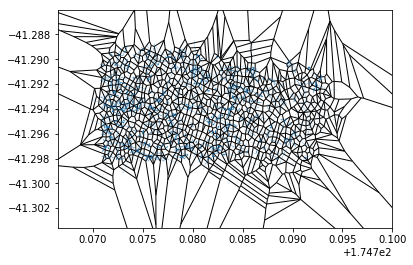

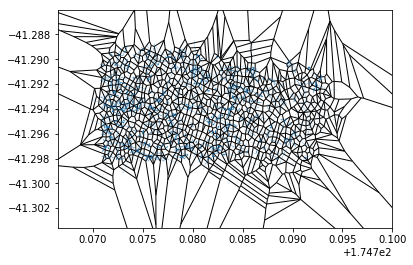

In [31]:
spatial.voronoi_plot_2d(vor, show_vertices=False, point_size=0.1)

In [34]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        if p1 in all_ridges:
            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]
            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    # finite ridge: already in the region
                    continue
                # Compute the missing endpoint of an
                # infinite ridge
                t = vor.points[p2] - \
                    vor.points[p1]  # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal
                midpoint = vor.points[[p1, p2]]. \
                    mean(axis=0)
                direction = np.sign(
                    np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + \
                    direction * radius
                new_region.append(len(new_vertices))
                new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

In [35]:
regions, vertices = voronoi_finite_polygons_2d(vor)

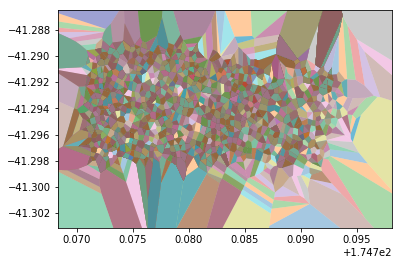

In [36]:
for region in regions:
    polygon = vertices[region]
    pyplot.fill(*zip(*polygon), alpha=0.4)
    
#pyplot.plot(pts['lon'], pts['lat'], 'ko', markersize=.5)
pyplot.xlim(vor.min_bound[0] - 0.001, vor.max_bound[0] + 0.001)
pyplot.ylim(vor.min_bound[1] - 0.001, vor.max_bound[1] + 0.001)

pyplot.show()

In [37]:
pip install pytess

  Stored in directory: C:\Users\vanvlesth\AppData\Local\pip\Cache\wheels\e6\a9\0c\deb8003b037eb99504cb256ea963c6880bafd36e4d0cce6ce0
Successfully built pytess
Note: you may need to restart the kernel to use updated packages.


In [42]:
import pytess
voronoipolys = pytess.voronoi(list(array_points))

In [51]:
gs = geopandas.GeoSeries([shp.geometry.Polygon(p[1]) for p in voronoipolys])

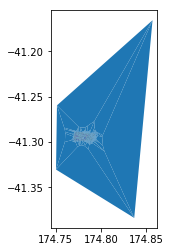

In [53]:
gs.plot()

In [ ]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)